%load_ext autoreload
%autoreload 2

In [37]:
from utils import *

In [38]:
import glob
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import re

In [39]:
paths = sorted(glob.glob(os.path.join(RAW_DATA_PATH, '*.csv')))

In [40]:
paths[:10]

[]

In [42]:
os.path.basename(paths[10])
os.path.basename(paths[0])

IndexError: list index out of range

In [36]:
nonEVpath = '../Copy of VED_Static_Data_ICE&HEV.csv'
nonEVs = pd.read_csv(nonEVpath)
nonEVs
nonEV_IDs = pd.Series(nonEVs.VehId)
nonEV_IDs

FileNotFoundError: [Errno 2] No such file or directory: '../Copy of VED_Static_Data_ICE&HEV.csv'

In [16]:
nonEVs.loc[nonEVs['VehId'] == 2, 'Vehicle Type'][0]

'ICE'

In [17]:
data = pd.read_csv(paths[0])
print(paths[0])

/home/aysola/midas-applied-ds/Data/Raw/VED/VED_171101_week.csv


In [18]:
data['Trip'][0]

706

In [19]:
data['Trip'].value_counts()

1866    6358
736     3391
789     3116
990     3016
982     2958
        ... 
893      106
60       106
325      105
1599     103
768      101
Name: Trip, Length: 658, dtype: int64

In [20]:
data.columns

Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Latitude[deg]',
       'Longitude[deg]', 'Vehicle Speed[km/h]', 'MAF[g/sec]',
       'Engine RPM[RPM]', 'Absolute Load[%]', 'OAT[DegC]', 'Fuel Rate[L/hr]',
       'Air Conditioning Power[kW]', 'Air Conditioning Power[Watts]',
       'Heater Power[Watts]', 'HV Battery Current[A]', 'HV Battery SOC[%]',
       'HV Battery Voltage[V]', 'Short Term Fuel Trim Bank 1[%]',
       'Short Term Fuel Trim Bank 2[%]', 'Long Term Fuel Trim Bank 1[%]',
       'Long Term Fuel Trim Bank 2[%]'],
      dtype='object')

In [38]:
ave_speed_func = lambda x: x['Vehicle Speed[km/h]'].mean()
ave_speed = extract_trip_info(paths[:2], ave_speed_func)

100%|██████████| 2/2 [01:09<00:00, 34.79s/it]


In [39]:
ave_speed

,Trip,values
0,1866,5.864737
1,736,25.347095
2,789,55.677340
3,990,38.500205
4,982,37.081812
...,...,...
1038,1110,69.907407
1039,1057,39.809524
1040,310,45.211538
1041,1301,44.634615


(array([  8.,  74., 235., 356., 223.,  84.,  33.,  14.,  12.,   2.]),
 array([  2.61940299,  12.81421556,  23.00902814,  33.20384071,
         43.39865329,  53.59346586,  63.78827844,  73.98309101,
         84.17790359,  94.37271616, 104.56752874]),
 <BarContainer object of 10 artists>)

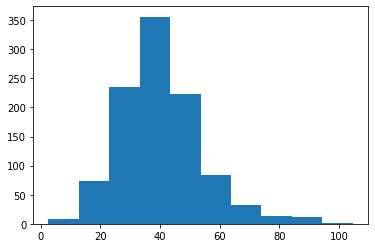

In [32]:
plt.hist(ave_speed['values'])

In [54]:
all_data = extract_trip_info(RAW_PATHS, ave_speed_func, name='averageSpeed')

100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


In [39]:
all_data.shape

(4153, 2)

In [47]:
max_speed_func = lambda x:x['Vehicle Speed[km/h]'].max()
max_speed = extract_trip_info(RAW_PATHS, max_speed_func, name = 'maxSpeed')

100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


In [55]:
all_data = pd.merge(all_data, max_speed, on='Trip')

In [56]:
all_data

,Trip,averageSpeed,maxSpeed
0,1866,54.706383,68.0
1,736,44.024490,69.0
2,789,41.033951,75.0
3,990,51.011009,75.0
4,982,62.472637,91.0
...,...,...,...
4148,3054,45.772321,73.0
4149,3473,49.724551,81.0
4150,11580,39.347682,63.0
4151,8788,50.596364,82.0


In [7]:
'''
Instantaneous Fuel Consumption Algorithm (MAF, Absolute Load, Displacement_eng, RPM_eng):
    if Fuel Rate is available then
        return Fuel Rate
    else if MAF is available then
        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)
        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)
        return Inst Fuel Consumption Rate
    else if Absolute Load and RPM_eng are available then
        MAF = 1.84 * displacement * absLoad/100 * RPM/2/60
        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)
        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)
        return Inst Fuel Consumption Rate
    else
        return NaN
'''


'\nInstantaneous Fuel Consumption Algorithm (MAF, Absolute Load, Displacement_eng, RPM_eng):\n    if Fuel Rate is available then\n        return Fuel Rate\n    else if MAF is available then\n        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)\n        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)\n        return Inst Fuel Consumption Rate\n    else if Absolute Load and RPM_eng are available then\n        MAF = 1.84 * displacement * absLoad/100 * RPM/2/60\n        Fuel Flow (l/h) = (MAF * 3600)(AFR * FD)\n        Inst Fuel Consumption Rate (l/km) = Fuel Flow / Speed (km)\n        return Inst Fuel Consumption Rate\n    else\n        return NaN\n'

In [70]:
pd.NA

<NA>

In [12]:
def inst_fuel_algo(MAF, absLoad, RPM, vehicle_speed, VehID, nonEV_IDs):

    if MAF is not 'NaN':
        fuel_flow = (MAF * 3600)/(14.7 * 820)
        if vehicle_speed == 0:
            return 0
        inst_rate = fuel_flow / vehicle_speed
        if inst_rate is 'inf':
            return 0
        return inst_rate
    elif absLoad is not 'NaN':
        displacement = nonEVs.loc[nonEVs['VehId'] == VehID, 'Engine Configuration & Displacement'][0]
        displacement = float(displacement.split(" ")[1].strip("L"))
        MAF = 1.84 * displacement * absLoad/100 * RPM/2/60
        fuel_flow = (MAF * 3600)/(14.7 * 820)
        if vehicle_speed is 0:
            return 0
        inst_rate = fuel_flow / vehicle_speed
        if np.isinf(inst_rate):
            return 0
        return inst_rate
    else:
        return 'NaN'
    
def fuel_algo(x):
    # first do everything for MAF non NA
    # then for all MAF NA values, do absLoad calculation
    # Because NA denom or numer => NAN => NA in both => NAN
    sec_hour = 3600
    air_to_fuel = 14.7
    fuel_density = 820
    
    out = pd.DataFrame(np.zeros(shape=(len(x))))
    
    maf_screen = np.array(x['MAF[g/sec]'].isna()).reshape(-1,1)
    maf = x[maf_screen]['MAF[g/sec]']
    fuel_flow = (maf*sec_hour)/(air_to_fuel*fuel_density)
    out[maf_screen] = list(fuel_flow/x[maf_screen]['Vehicle Speed[km/h]'])
    
    VehID = x['VehId'].iloc[0]
    absLoad = x[~maf_screen]['Absolute Load[%]']
    RPM = x[~maf_screen]['Engine RPM[RPM]']
    fuel_flow = x[~maf_screen]['MAF[g/sec]']
    displacement = nonEVs.loc[nonEVs['VehId']==VehID, 'Engine Configuration & Displacement']
    if len(displacement) == 0:
        return pd.DataFrame(np.zeros(shape=(len(x))))
    displacement = displacement.iloc[0]
    displacement = re.findall(r"\d\.\d",displacement)
    if len(displacement) != 1:
        raise Exception('Something Broke in displacement string search')
    displacement = float(displacement[0].strip("L"))
    maf = 1.84 * displacement * absLoad/100 * RPM/2/60
    out[~maf_screen] = list((maf*sec_hour)/(air_to_fuel*fuel_density)) #update out where MAF is NAN
    
    out.replace(float('inf'), 0, inplace=True)
    
    return list(out.iloc[:,0])
    
    
    
    
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)
        

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-12-ed4d7b2d3908>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if MAF is not 'NaN':
<ipython-input-12-ed4d7b2d3908>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if inst_rate is 'inf':
<ipython-input-12-ed4d7b2d3908>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif absLoad is not 'NaN':
<ipython-input-12-ed4d7b2d3908>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if vehicle_speed is 0:


In [13]:
nonEVs

NameError: name 'nonEVs' is not defined

In [11]:
#data['fuel rate'] = data.apply(lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'] ),axis=1)
fuel_rate_func = lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'], nonEV_IDs )
#trip_706['final_lat'] = trip_706['Latitude[deg]'].shift(1)
#trip_706['final_lon'] = trip_706['Longitude[deg]'].shift(1)


In [12]:
x = data[data['Trip']==237]

NameError: name 'data' is not defined

In [207]:
x['VehId']

471573    489
471574    489
471575    489
471576    489
471577    489
         ... 
473521    489
473522    489
473523    489
473524    489
473525    489
Name: VehId, Length: 1953, dtype: int64

In [208]:
nonEVs[nonEVs['VehId']==489]

,VehId,Vehicle Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
276,489,ICE,NO DATA,6-242-MFI 4.0L,NO DATA,NO DATA,4000


In [11]:
# fuel_rate = extract_trip_info(paths[:1], fuel_rate_func)
fuel_rate = extract_trip_info(paths[:1], fuel_algo)

NameError: name 'fuel_algo' is not defined

In [1]:
(fuel_rate.iloc[10]['values'])


NameError: name 'fuel_rate' is not defined

In [8]:
fuel_rate.loc[fuel_rate["Trip"] == 1866].values

NameError: name 'fuel_rate' is not defined

In [258]:
trip_706 = data.loc[data['Trip'] == 291]
#trip_706['fuel rate1'] = trip_706.apply(lambda x: inst_fuel_algo(x['MAF[g/sec]'],x['Absolute Load[%]'],x['Engine RPM[RPM]'],x['Vehicle Speed[km/h]'], x['VehId'], nonEV_IDs),axis=1)


In [259]:
trip_706


,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%],fuel rate
